## Text Generation
#### Generation => Continous Prediction
This Project is Devided into 2 parts :
- Data Preprocessing
- Model Creation, Training and Testing

#### Data Source
Downloading a free E-Book From Project Gutenburg

### Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import visualkeras
import pydot_ng
import pydotplus
import graphviz
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings('ignore')

### Data Preprocessing

#### Essential Functions

In [2]:
def get_data(file_path) :
    ## creating a file object
    file = open(file_path, encoding="utf8")
    ## reading data from file
    sentences = file.read().lower().split('\n')
    ## returning data
    return sentences

In [3]:
def get_numeric_sequences(sentences) :
    ## creating tokenizer, with limit of all words.
    token = Tokenizer()
    ## train the tokenizer to create word index of each unique word.
    token.fit_on_texts(sentences)
    ## A dictionary of words mapped to integers
    word_indecies = token.word_index
    ## converting text sentences to numerical sequences
    sequences = token.texts_to_sequences(sentences)
    ## returning sequences
    return sequences, word_indecies, token

In [4]:
def data_augmentaion(sequences) :
    ## this function is made to create n_gram sequences
    n_gram_sequences = list()
    ## iterating all sequences
    for sequence in sequences :
        ## for each sequences creating subsequences
        for i in range(len(sequence)) :
            n_gram_sequences.append(sequence[0:i + 1])
    ## returning all sequences
    return n_gram_sequences

In [5]:
def get_pad_sequences(n_gram_sequences) :
    ## getting maximum length sequence
    max_seq_len = max([len(seq) for seq in n_gram_sequences])
    ## padding the sequences
    padded_sequences = pad_sequences(n_gram_sequences, maxlen = max_seq_len)
    ## returning padded sequences.
    return padded_sequences, max_seq_len

In [6]:
def get_train_data(padded_sequences) :
    x_train = padded_sequences[:, : -1]
    y_train = padded_sequences[:, -1]
    ## returning training data
    return x_train, y_train

In [7]:
def data_preprocessing(file_path) :
    ## getting data from file
    sentences = get_data(file_path)
    ## getting numerical sequences and word indecies
    numerical_sequences, word_indecies, token = get_numeric_sequences(sentences)
    ## getting n_gram_sequences
    n_gram_sequences = data_augmentaion(numerical_sequences)
    ## padding the sequences
    padded_sequences, max_seq_len = get_pad_sequences(n_gram_sequences)
    ## getting training data
    x_train, y_train = get_train_data(padded_sequences)
    ## creating categorical Y
    vocab_size = len(word_indecies) + 1 ## since indexing was 1 based, i am incrementing size by 1
    y_train_categorical = to_categorical(y_train, num_classes= vocab_size, dtype='int')
    ## returning the desired things
    return x_train, y_train, y_train_categorical, word_indecies, vocab_size, max_seq_len, token

#### Driver Code of Data Preprocessing Part

In [8]:
x_train, y_train, y_train_categorical, word_index, vocab_size, max_seq_len, token = data_preprocessing('Book.txt')
x_train.shape, y_train.shape, y_train_categorical.shape, vocab_size, max_seq_len

((8270, 15), (8270,), (8270, 2186), 2186, 16)

### Creating, Training and Testing the Model

#### Model Architecture

In [9]:
class Text_Generation :
    def __init__(self, vocab_size, tokenizer, max_seq_len, word_index) :
        self.token = tokenizer
        self.max_seq_len = max_seq_len
        self.word_index = word_index
        self.model = Sequential()
        self.model.add(Embedding(input_dim=vocab_size, output_dim=250, input_length=max_seq_len - 1))
        self.model.add(Bidirectional(LSTM(units=256)))
        self.model.add(Dense(units=vocab_size, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    def fit(self, x_train, y_train_categorical) :
        self.model.fit(x_train, y_train_categorical, epochs = 15)
    
    def predict(self, seed_text, next_words = 100) :
        for i in range(next_words) :
            sequence = self.token.texts_to_sequences([seed_text])
            padded_sequence = pad_sequences(sequence, maxlen = max_seq_len - 1)
            next_word_predicted = self.model.predict(padded_sequence)
            next_word_index = np.argmax(next_word_predicted)
            word = ' '
            for key, val in word_index.items() :
                if (val == next_word_index) :
                    word += key
            seed_text += word
        return seed_text
    
    def visualize(self) :
        return keras.utils.plot_model(
            self.model,
            to_file="Clf.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True,
            show_trainable=False,
        )

#### Creating Classifier

In [10]:
clf = Text_Generation(vocab_size, token, max_seq_len, word_index)

#### Training the Model

In [11]:
clf.fit(x_train, y_train_categorical)

Epoch 1/15
259/259 [==============================] - 27s 94ms/step - loss: 6.6935 - accuracy: 0.0522
Epoch 2/15
259/259 [==============================] - 25s 96ms/step - loss: 6.1225 - accuracy: 0.0727
Epoch 3/15
259/259 [==============================] - 24s 94ms/step - loss: 5.7296 - accuracy: 0.0933
Epoch 4/15
259/259 [==============================] - 25s 96ms/step - loss: 5.2326 - accuracy: 0.1253
Epoch 5/15
259/259 [==============================] - 25s 95ms/step - loss: 4.6854 - accuracy: 0.1596
Epoch 6/15
259/259 [==============================] - 25s 97ms/step - loss: 4.0876 - accuracy: 0.2128
Epoch 7/15
259/259 [==============================] - 25s 95ms/step - loss: 3.4632 - accuracy: 0.2906
Epoch 8/15
259/259 [==============================] - 25s 95ms/step - loss: 2.8624 - accuracy: 0.4021
Epoch 9/15
259/259 [==============================] - 25s 96ms/step - loss: 2.3156 - accuracy: 0.5224
Epoch 10/15
259/259 [==============================] - 25s 95ms/step - loss: 1.875

#### Testing the Model

In [12]:
## seed text can also be taken as an input from user.
seed_text = 'This ebook is for the use of anyone anywhere in the United States and most other parts of'
generated_output_text = clf.predict(seed_text)

1/1 [==============================] - 0s 8ms/step


In [13]:
print(generated_output_text)

This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions restrictions and how to his part i shall decided that a voluminous forged with his one were love her while the were until i had been loved and it was the social used on his part for an waves she dropped which he will then you to show the packet the living sympathetic at my suggestion so the impression of his loved will used in www gutenberg org you are a curiosity ridden while the united states we do not do not thus thus it it it is no never


#### Visualizing The Model

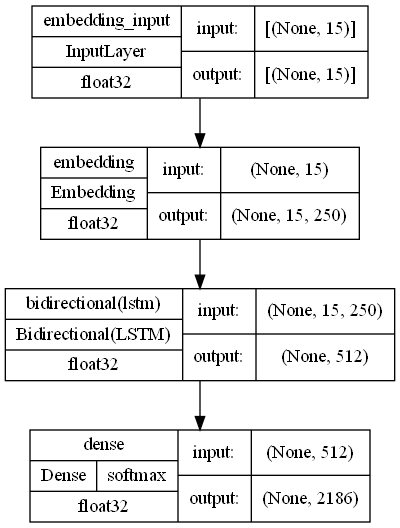

In [14]:
clf.visualize()